In [ ]:
pip install gspread oauth2client pandas joblib

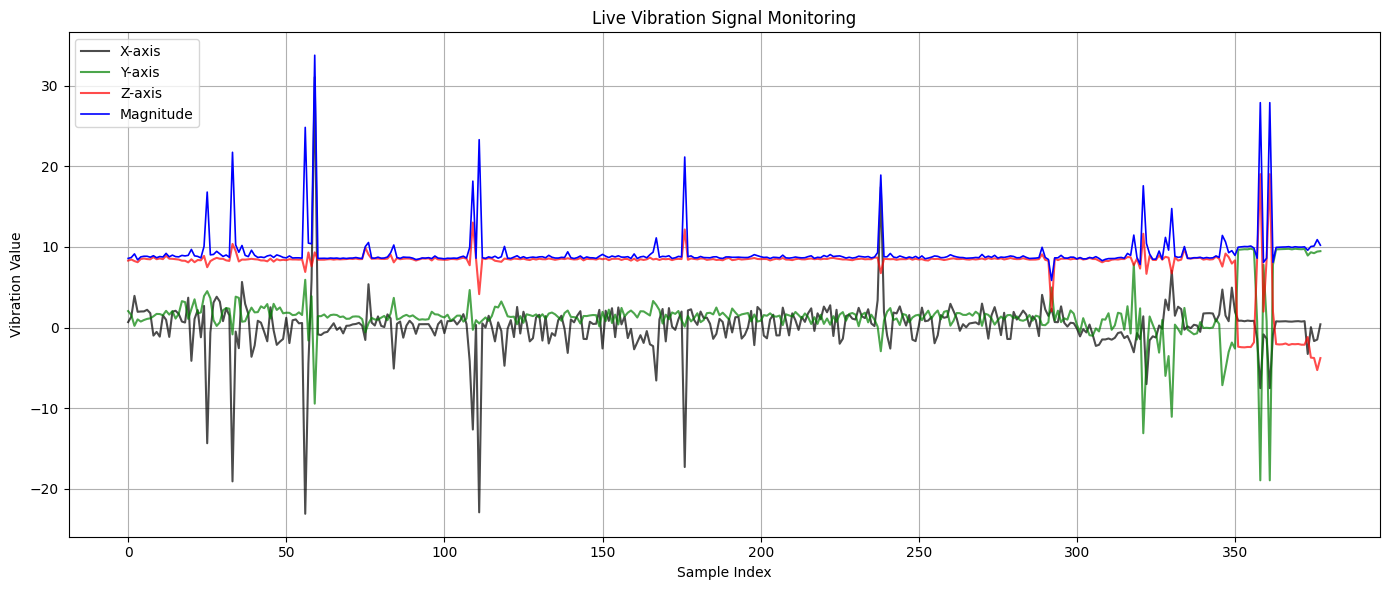

     x_axis  y_axis  z_axis fault_detected
373   -3.28    8.93   -1.18       ⚠️ Fault
374    0.05    9.33   -3.73       ✅ Normal
375   -1.68    9.22   -3.78       ✅ Normal
376   -1.49    9.42   -5.28       ⚠️ Fault
377    0.40    9.47   -3.79       ✅ Normal


In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
import joblib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output  # For Google Colab live plot

# 1. Setup Google Sheets connection
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("advance-sonar-457111-f6-025734c7b1cc.json", scope)
client = gspread.authorize(creds)

# 2. Open your Google Sheet
sheet = client.open("Vibration_data_Project").sheet1

# 3. Load model and scaler
model = joblib.load('rf_vibration_model.pkl')
scaler = joblib.load('scaler_vibration.pkl')

# 4. Get data and predict faults
def get_latest_data():
    data = sheet.get_all_records()
    df = pd.DataFrame(data)

    if df.empty or 'x_axis' not in df or 'y_axis' not in df or 'z_axis' not in df:
        return pd.DataFrame()  # Return empty if structure is not ready

    # Feature engineering
    df['magnitude'] = np.sqrt(df['x_axis']**2 + df['y_axis']**2 + df['z_axis']**2)
    df['rolling_mean'] = df['magnitude'].rolling(window=20, min_periods=1).mean()
    df['rolling_std'] = df['magnitude'].rolling(window=20, min_periods=1).std()

    features = df[['x_axis', 'y_axis', 'z_axis', 'magnitude', 'rolling_mean', 'rolling_std']]
    features_scaled = scaler.transform(features)

    df['prediction'] = model.predict(features_scaled)
    df['fault_detected'] = df['prediction'].apply(lambda x: '⚠️ Fault' if x == 1 else '✅ Normal')

    return df

# 5. Live update loop
while True:
    result_df = get_latest_data()

    if not result_df.empty:


        # Clear previous output (for Colab/live environments)
        clear_output(wait=True)

        # Plot the vibration signals
        plt.figure(figsize=(14, 6))
        plt.plot(result_df.index, result_df['x_axis'], label='X-axis', color='black', alpha=0.7)
        plt.plot(result_df.index, result_df['y_axis'], label='Y-axis', color='green', alpha=0.7)
        plt.plot(result_df.index, result_df['z_axis'], label='Z-axis', color='red', alpha=0.7)
        plt.plot(result_df.index, result_df['magnitude'], label='Magnitude', color='blue', linewidth=1.2)

        plt.title("Live Vibration Signal Monitoring")
        plt.xlabel("Sample Index")
        plt.ylabel("Vibration Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Display last few predictions
        print(result_df[['x_axis', 'y_axis', 'z_axis', 'fault_detected']].tail(5))

    time.sleep(10)  # wait before next update
